In [ ]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")

In [ ]:
# !pip install -U -q PyDrive
# !pip install -U scikit-learn
!pip install scikit-surprise
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811610 sha256=3ecf2e359f82b0da5550a9aa1d58f9034541a159cd0a97254606047c49a79fba
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from google.colab import drive

drive.mount('/gdrive')

!ln -s "/gdrive/My Drive/Book data"

Mounted at /gdrive


# Book Dataset Testing (Goodbooks)

DATA LOADING

In [ ]:
df1 = pd.read_csv('/content/Book data/Goodbooks/Ratings(Final format).txt', header = None, names = ['Cust_Id','Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (991756, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


In [ ]:
df2 = pd.read_csv('/content/Book data/Goodbooks/Ratings(Final format).txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df3 = pd.read_csv('/content/Book data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df4 = pd.read_csv('/content/Book data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
# df3['Rating'] = df3['Rating'].astype(float)
# df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
# print('Dataset 3 shape: {}'.format(df3.shape))
# print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (991756, 2)


In [ ]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (991756, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


# DATA VIEWING

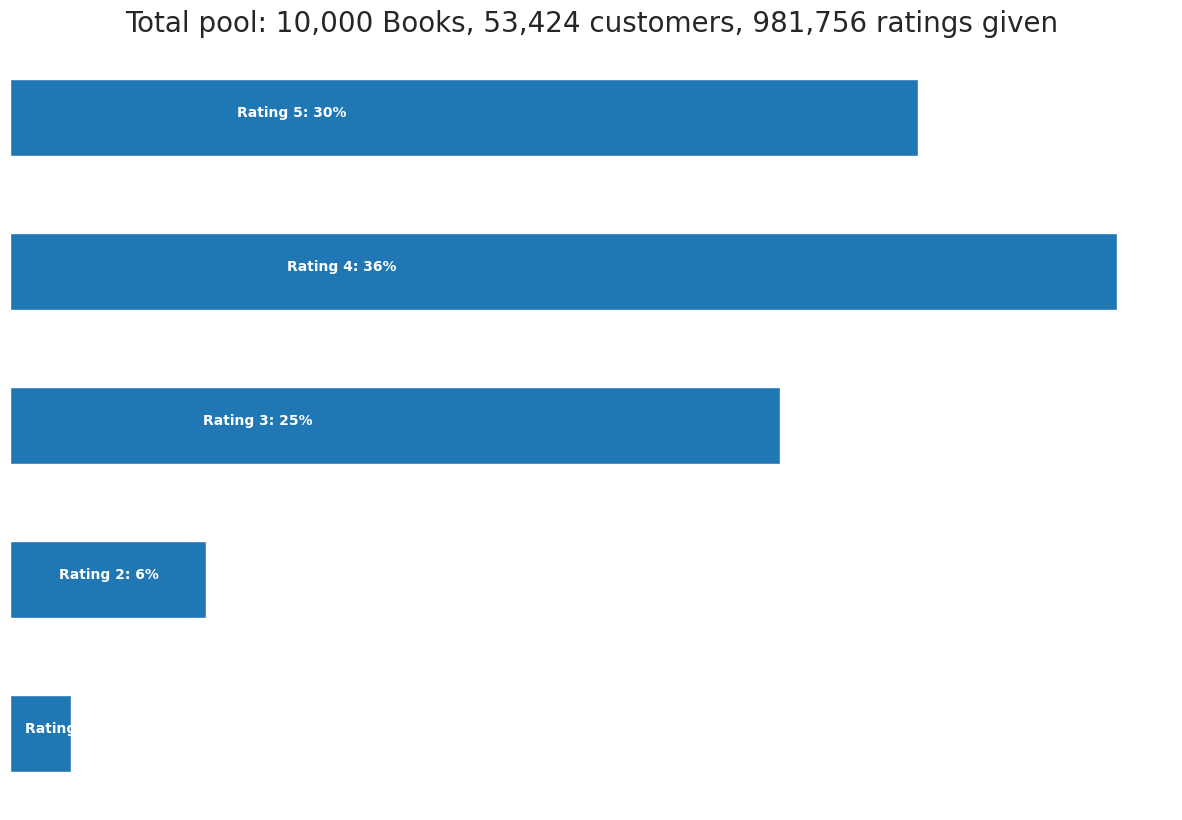

In [ ]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
Book_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - Book_count

# get rating count
rating_count = df['Cust_Id'].count() - Book_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Books, {:,} customers, {:,} ratings given'.format(Book_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# DATA CLEANING

In [ ]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

book_np = []
book_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), book_id)
    book_np = np.append(book_np, temp)
    book_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),book_id)
book_np = np.append(book_np, last_record)

print('Book numpy: {}'.format(book_np))
print('Length: {}'.format(len(book_np)))

Book numpy: [1.e+00 1.e+00 1.e+00 ... 1.e+04 1.e+04 1.e+04]
Length: 981756


In [ ]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Book_id'] = book_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
   Cust_Id  Rating  Book_id
1      314     5.0        1


<ipython-input-9-c709382d0f32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Book_id'] = book_np.astype(int)
<ipython-input-9-c709382d0f32>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


DATA SLICING

In [ ]:
f = ['count','mean']

df_book_summary = df.groupby('Book_id')['Rating'].agg(f)
df_book_summary.index = df_book_summary.index.map(int)
book_benchmark = round(df_book_summary['count'].quantile(0.7),0)
drop_book_list = df_book_summary[df_book_summary['count'] < book_benchmark].index

print('Book minimum times of review: {}'.format(book_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Book minimum times of review: 100.0
Customer minimum times of review: 18.0


DATA TRIMMING

* ONLY USE IF DATA IS TOO LARGE TO RUN



In [ ]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Book_id'].isin(drop_book_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (981756, 3)
After Trim Shape: (648587, 3)
-Data Examples-
   Cust_Id  Rating  Book_id
1      314     5.0        1


In [ ]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Book_id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)

(53424, 10000)


# DATA MAPPING

In [ ]:
df_title = pd.read_csv('/content/Book data/Goodbooks/books (Modified).csv', encoding = "ISO-8859-1", header = None, names = ['Book_id', 'Year', 'Name'])
df_title.set_index('Book_id', inplace = True)
print (df_title.head(10))

           Year                                               Name
Book_id                                                           
1        2008.0            The Hunger Games (The Hunger Games, #1)
2        1997.0  Harry Potter and the Sorcerer's Stone (Harry P...
3        2005.0                            Twilight (Twilight, #1)
4        1960.0                              To Kill a Mockingbird
5        1925.0                                   The Great Gatsby
6        2012.0                             The Fault in Our Stars
7        1937.0                                         The Hobbit
8        1951.0                             The Catcher in the Rye
9        2000.0              Angels & Demons  (Robert Langdon, #1)
10       1813.0                                Pride and Prejudice


In [ ]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Book_id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.84584265, 0.84212649, 0.84355483, 0.84413819, 0.84255868]),
 'test_mae': array([0.66122394, 0.65916777, 0.66022871, 0.65999581, 0.65810254]),
 'fit_time': (25.94324231147766,
  23.98709988594055,
  22.429687976837158,
  26.69296932220459,
  23.861756086349487),
 'test_time': (3.667300224304199,
  3.0118155479431152,
  3.417020797729492,
  2.4798598289489746,
  2.729498863220215)}

In [ ]:
df_19724 = df[(df['Cust_Id'] == 19724) & (df['Rating'] == 5)]
df_19724 = df_19724.set_index('Book_id')
df_19724 = df_19724.join(df_title)['Name']
print(df_19724)

Book_id
2       Harry Potter and the Sorcerer's Stone (Harry P...
4                                   To Kill a Mockingbird
5                                        The Great Gatsby
10                                    Pride and Prejudice
13                                   Nineteen Eighty-Four
                              ...                        
1641     Something Wicked This Way Comes (Green Town, #2)
1842                                        Perfect Match
2225      John Dies at the End (John Dies at the End, #1)
2264             Explosive Eighteen (Stephanie Plum, #18)
8609                                  The Lady of Shalott
Name: Name, Length: 62, dtype: object


In [ ]:
user_19724 = df_title.copy()
user_19724 = user_19724.reset_index()
user_19724 = user_19724[~user_19724['Book_id'].isin(drop_book_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Book_id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_19724['Estimate_Score'] = user_19724['Book_id'].apply(lambda x: svd.predict(19724, x).est)

user_19724 = user_19724.drop('Book_id', axis = 1)

user_19724 = user_19724.sort_values('Estimate_Score', ascending=False)
print(user_19724.head(10))

        Year                                               Name  \
24    2007.0  Harry Potter and the Deathly Hallows (Harry Po...   
1341  2002.0       Night Watch (Discworld, #29; City Watch, #6)   
306   2011.0  The Wise Man's Fear (The Kingkiller Chronicle,...   
3085  1990.0            Fables and Reflections (The Sandman #6)   
4482  1996.0  It's a Magical World: A Calvin and Hobbes Coll...   
1028  2012.0                            Saga, Vol. 1 (Saga, #1)   
7806  2004.0          Death Note, Vol. 4: Love (Death Note, #4)   
861   2014.0     Words of Radiance (The Stormlight Archive, #2)   
3659  1996.0                         The Wake (The Sandman #10)   
3394  1996.0                   The Kindly Ones (The Sandman #9)   

      Estimate_Score  
24          4.989761  
1341        4.987707  
306         4.971392  
3085        4.960443  
4482        4.894837  
1028        4.891139  
7806        4.885299  
861         4.876850  
3659        4.863842  
3394        4.857801  


In [ ]:
def recommend(book_title, min_count):
    print("For Book ({})".format(book_title))
    print("- Top 10 books recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == book_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_book_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

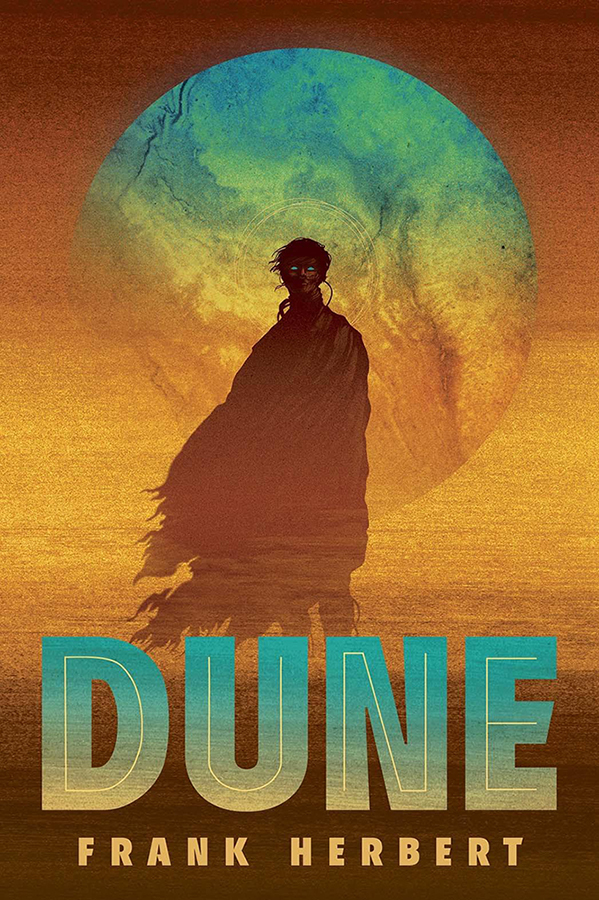

In [ ]:
recommend("Dune (Dune Chronicles #1)", 0)

For Book (Dune (Dune Chronicles #1))
- Top 10 books recommended based on Pearsons'R correlation - 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


 PearsonR                                                         Name  count  mean
      1.0                                                 The Yearling    100  3.88
      1.0                        Summer Knight (The Dresden Files, #4)    100  4.21
      1.0                                                 'Salem's Lot    100  4.29
      1.0 Book of Mormon, Doctrine and Covenants, Pearl of Great Price    100  4.21
      1.0        Across the Nightingale Floor (Tales of the Otori, #1)    100  4.05
      1.0                                            The Great Santini    100  4.07
      1.0      The Tale of the Body Thief (The Vampire Chronicles, #4)    100  3.36
      1.0                                     The Island of Dr. Moreau    100  3.53
      1.0                             Changes (The Dresden Files, #12)    100  4.39
      1.0                                              A Reliable Wife    100  3.34


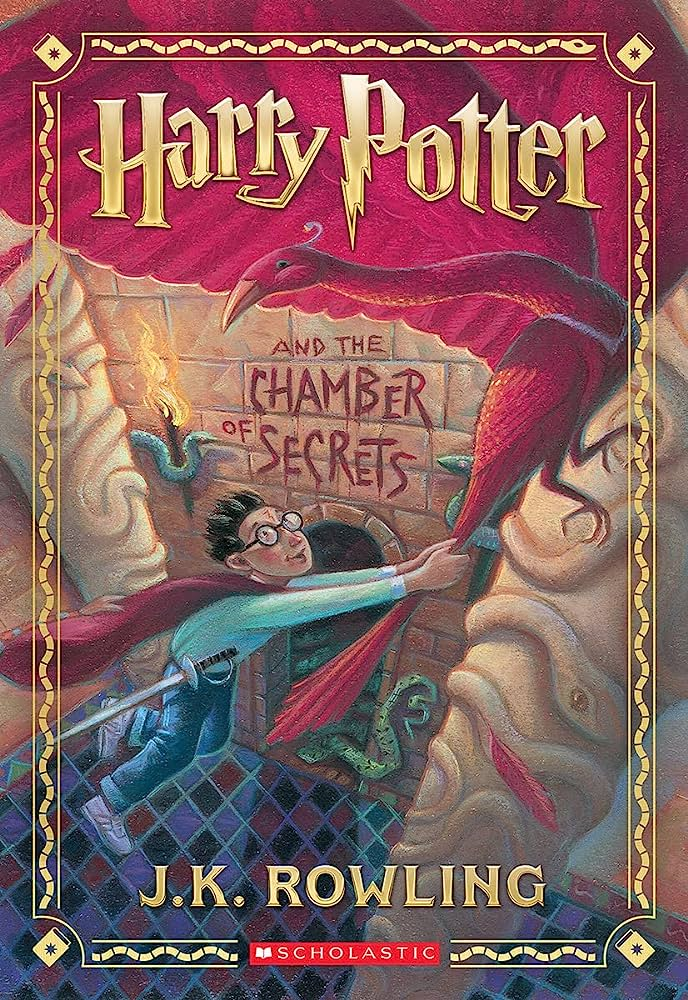

In [ ]:
recommend("Harry Potter and the Chamber of Secrets (Harry Potter, #2)", 0)

For Book (Harry Potter and the Chamber of Secrets (Harry Potter, #2))
- Top 10 books recommended based on Pearsons'R correlation - 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


 PearsonR                                          Name  count  mean
      1.0                      And the Mountains Echoed    100  4.14
      1.0                                     Black Boy    100  3.93
      1.0 The End (A Series of Unfortunate Events, #13)    100  3.89
      1.0 Jewels of the Sun (Gallaghers of Ardmore, #1)    100  4.02
      1.0                              The Razor's Edge    100  4.17
      1.0                                The Penelopiad    100  3.63
      1.0                              The Starter Wife    100  3.28
      1.0                Magic Slays (Kate Daniels, #5)    100  4.30
      1.0           Blood Rites (The Dresden Files, #6)    100  4.19
      1.0                       The Buddha in the Attic    100  3.52


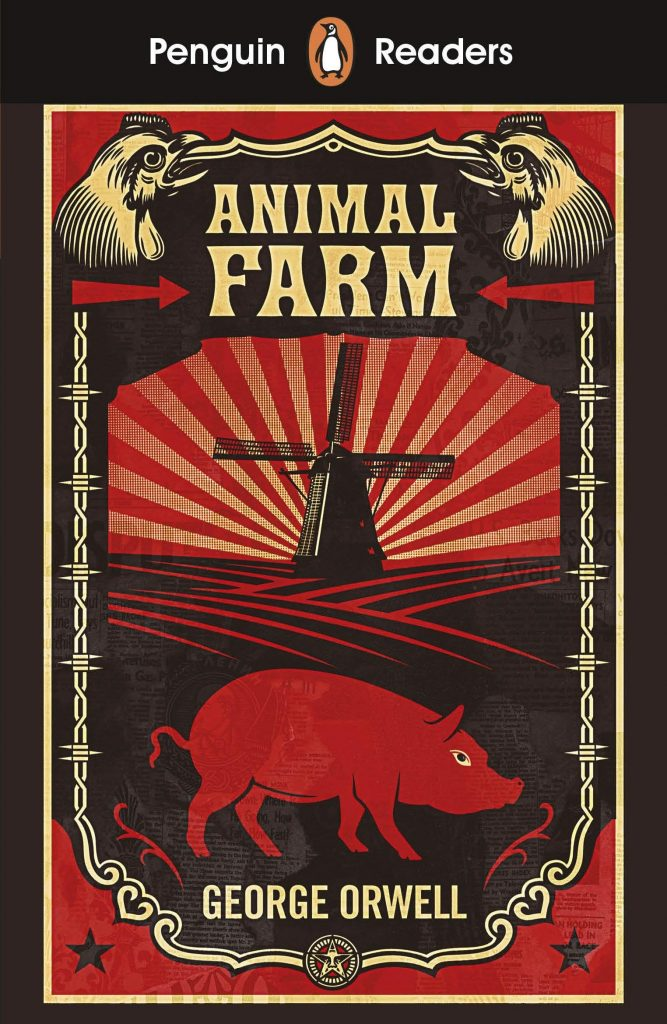

In [ ]:
recommend("Animal Farm", 0)

For Book (Animal Farm)
- Top 10 books recommended based on Pearsons'R correlation - 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


 PearsonR                                                                                                           Name  count  mean
      1.0                                                                                                            Ash    100  3.63
      1.0                                                                                           The Art of Happiness    100  3.97
      1.0                                                                        The Berenstain Bears and the Messy Room    100  4.20
      1.0                                                                                      The Hobbit: Graphic Novel    100  4.39
      1.0 Notes from Underground, White Nights, The Dream of a Ridiculous Man, and Selections from The House of the Dead    100  3.93
      1.0                                                                             The Time Machine/The Invisible Man    100  3.90
      1.0                                                     